<a href="https://colab.research.google.com/github/gitnicolas343/ejerciciosTAM-/blob/main/ejercicios_12_12_2024_PT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo completo para un problema de regresión usando sci-kitlearn

El siguiente ejemplo presenta las etapas básicas de un proyecto de analítica de datos en una tarea de regresión, orientadas a:

- Preproceso de atributos con campos vacios y tipo texto.
- Entrenamiento y selección de un modelo de regresión bajo una estrategia de validación cruzada.
- La utilización de diccionarios para la sintonización de hiperparámetros.
-Se ilustra también la creación de clases (objetos) propios compatibles con la clase pipeline de sci-kitlearn.

**Base de datos utilizada**: [FIFA 2019 - Kaggle](https://www.kaggle.com/datasets/devansodariya/football-fifa-2019-dataset).

In [1]:
#cargar datos desde drive acceso libre
FILEID = "15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

--2025-02-22 20:43:22--  https://docs.google.com/uc?export=download&confirm=&id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe
Resolving docs.google.com (docs.google.com)... 142.250.141.113, 142.250.141.101, 142.250.141.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe&export=download [following]
--2025-02-22 20:43:22--  https://drive.usercontent.google.com/download?id=15QxsIm_jMfHEy6Y--6o19IWgr66oiTRe&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.137.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4039371 (3.9M) [application/octet-stream]
Saving to: ‘codigos.zip’

codigos.zip         100%[===================>]   3.85M  --.

# Lectura de la base de datos con Pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#librerias para proceso
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

%matplotlib inline
csv_path = 'Main_Fifa/datos/data.csv' #directorio de la base de datos en disco de colaboratory según archivo cargado

Xdata = pd.read_csv(csv_path)#leer archivo csv

col_drop = ['Unnamed: 0', 'Name','ID','Photo','Flag',
           'Club Logo','Loaned From'] #variables a descartar - no contienen información relevante
Xdata.drop(columns = col_drop, inplace = True)
Xdata.head()

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,2202,Left,5.0,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,33,Portugal,94,94,Juventus,€77M,€405K,2228,Right,5.0,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,2143,Right,5.0,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,27,Spain,91,93,Manchester United,€72M,€260K,1471,Right,4.0,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,27,Belgium,91,92,Manchester City,€102M,€355K,2281,Right,4.0,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


# Identificar tipos de variables, campos perdidos y preproceso básico a realizar

In [3]:
Xdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 82 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       18207 non-null  int64  
 1   Nationality               18207 non-null  object 
 2   Overall                   18207 non-null  int64  
 3   Potential                 18207 non-null  int64  
 4   Club                      17966 non-null  object 
 5   Value                     18207 non-null  object 
 6   Wage                      18207 non-null  object 
 7   Special                   18207 non-null  int64  
 8   Preferred Foot            18159 non-null  object 
 9   International Reputation  18159 non-null  float64
 10  Weak Foot                 18159 non-null  float64
 11  Skill Moves               18159 non-null  float64
 12  Work Rate                 18159 non-null  object 
 13  Body Type                 18159 non-null  object 
 14  Real F

## Se presentan atributos tipo int, float y texto, algunos de ellos con datos perdidos.

# Partición en conjunto de training y testing.

## Tips básicos para escoger la estrategia de validación:

- Para $N\geq 5000$ se sugiere realizar entrenamiento hold-out, generando grupos de entrenamiento, validación y evaluación. Los conjuntos de entrenamiento y validación se pueden utilizar para realizar validación cruzada de 10 o 5 folds para determinar el mejor modelo y sus hiperparámetros.

- No obstante, si la cantidad de datos es muy grande, generalmente se utiliza un único conjunto de entrenamiento y un único conjunto de validación, e.g., modelos de deep learning generalmente utilizan esta estrategia por la gran cantidad de datos disponible.

**HoldOut con única partición de entrenamiento, validación y evaluación (training, validation, testing)**

![HoldOut](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/3_Intro_Sklearn_Regresion/HoldOut.png?raw=1)


**HoldOut utilizando validación cruzada para definir varios conjuntos de entrenamiento y validación en la búsqueda del mejor modelo con evaluación final en un único conjunto de testing**

![grid_search_cross_validation](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/3_Intro_Sklearn_Regresion/crossvalidation.png?raw=1)

- Se sugiere para $ 30 <N <5000$ realizar validación cruzada o validación cruzada anidad k folds (generalmente se trabaja con k=10 o k = 5), y reportar el desempeño promedio en el conjunto de test a lo largo de las rotaciones.

- En algunos textos, dado que los datos se rotan y aparecen al menos una vez en el conjunto de training y una vez en el de testing, se habla solamente de conjuntos de entrenamiento y validación, porque el concepto de datos afuera (testing) se pierde.

![kfolds](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/3_Intro_Sklearn_Regresion/kfolds.png?raw=1)

- La validación cruzada anidad es mucho más estricta a la hora de dejar un conjunto de test que no se utiliza para sintonizar los hiperparámetros (a diferencia del kfolds convencional que determina los mejores valores de hiperparámetros respecto al conjunto de validación=evaluación). Sin embargo, la validación anidad es más costosa computacionalmente.


![nestedcv](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/3_Intro_Sklearn_Regresion/nestedcv.png?raw=1)

- Para $N \leq 30$ se sugiere trabajar con validación cruzada fijando el número de particiones igual al número de datos ($k=N$). En este caso, se tiene un conjunto de entrenamiento de $N-1$ y una única muestra de test que se rota $N$ veces (leave-one-out).



**Nota**: Para el ejemplo ilustrado se cuenta con una buena cantidad de datos 18.000 aprox., por lo que se realizará una validación hold-out, con 70% de datos para entrenamiento y 30% para evaluación. Sobre el conjunto de entrenamiento se realizará una validación cruzada de 5 folds (k=5) para determinar el mejor modelo e hiperparámetros.

Se define el atributo Release Clause como salida.

In [4]:
# Partición entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%

Xtrain, Xtest = train_test_split(Xdata,test_size=0.3)
col_sal = "Release Clause"
ytrain = Xtrain[col_sal]
ytest = Xtest[col_sal]
Xtrain.drop(columns=col_sal,inplace=True)
Xtest.drop(columns=col_sal,inplace=True)


**Nota**: Recuerde que puede usar la partición estratificada para preservar la distribución de la salida de interés en los folds

# Preproceso: completar datos y codificar datos tipo texto


In [5]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")#se utiliza estimador de moda
ytrain = imputer.fit_transform(pd.DataFrame(ytrain)).reshape(-1)#ajuste sobre la salida
ytest = imputer.transform(pd.DataFrame(ytest)).reshape(-1)#evaluar sobre datos de test

print(ytrain.shape, ytest.shape)

(12744,) (5463,)


**Nota**: Dado que la variable de salida esta en formato moneda se debe codificar meidante función particular (custom). También, se creará una función para codificar las variables tipo evolución características del jugador.

---



In [6]:
ytrain[0]

'€891K'

In [7]:
 #codificar variables moneda
def code_euro(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y[i][-1]=='M': yc[i] = float(y[i][1:-1])*10**6 #buscar M y reemplazar 10^6
        elif y[i][-1]=='K': yc[i] = float(y[i][1:-1])*10**3 # buscar K y reemplazar por 10^3
        else: yc[i] = float(y[i][1:])
    return yc

#codificar estadísticas
def code_stats(y):
    yc = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y.iloc[i].find("+") > -1: # encontrar signo + en str y casteo a flotante
            yc[i] = float(y.iloc[i][:y.iloc[i].find("+")])+float(y.iloc[i][y.iloc[i].find("+")+1:])
        else: yc[i] = float(y.iloc[i])
    return yc

In [8]:
#codificar salida
ytrain_num = code_euro(ytrain)
ytest_num = code_euro(ytest)

In [9]:
ytrain_num[:5]

array([ 891000.,  724000., 1100000., 7700000.,  656000.])

## Se definen las variables para codificar utilizando las funciones establecidas de moneda, estadísticas y las tipo texto con OrdinalEncoder y OneHotEncoder.

In [10]:
#definir columnas tipo string  para codificar moneda, estadistica fifa y categoricas
col_euro = ['Value','Wage'] #variables tipo moneda
col_stats = ['LS','ST','RS','LW','LF','CF','RF','RW','LAM',
             'CAM','RAM','LM','LCM','CM','RCM','RM','LWB',
             'LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB']#variables tipo mejora jugadores

cat = ['Nationality','Club','Body Type','Position','Preferred Foot',
        'Work Rate','Real Face','Contract Valid Until']#variables a codificar OrdinalEncoder y OneHotEncoder
items = []
for i in cat:
    items += [list(Xdata[i].value_counts().index)]
cat_usr = dict(zip(cat, items))#se crean diccionarios con las variables y sus posibles valores

In [11]:
Xdata['Nationality'].value_counts()

,count
Nationality,
England,1662
Germany,1198
Spain,1072
Argentina,937
France,914
...,...
Belize,1
Liberia,1
Lebanon,1


In [12]:
cat_usr.keys()

dict_keys(['Nationality', 'Club', 'Body Type', 'Position', 'Preferred Foot', 'Work Rate', 'Real Face', 'Contract Valid Until'])

In [13]:
cat_usr['Body Type']

['Normal',
 'Lean',
 'Stocky',
 'Messi',
 'C. Ronaldo',
 'Neymar',
 'Courtois',
 'PLAYER_BODY_TYPE_25',
 'Shaqiri',
 'Akinfenwa']

# Se crea clase propia (custom) para ejecutar el preproceso que sea compatible con scikitlearn

In [14]:
#%% transformer custom
from sklearn.base import BaseEstimator, TransformerMixin #objetos básicos para herencia de clase

class mypre_fifa(BaseEstimator,TransformerMixin):
    #inicializacion de clase y varaibles
    def __init__(self, col_euro,col_stats, cat_usr): #constructor clase
        self.col_euro = col_euro #lista atributos tipo moneda
        self.col_stats = col_stats #lista atributos tipo estadistica
        self.cat_usr = cat_usr #lista de atributos categoricos

    def fit(self,X, *_):#función de ajuste -> *_ para indicar que puede recibir más entradas en el pipeline
        Xi = X.copy() #copiar dataset para no reemplazar original
        self.imputer_num = SimpleImputer(strategy="most_frequent") #crear imputador tipo moda
        self.a = Xi.columns[np.sum(Xi.isna())> 0] #encontrar columnas con datos faltantes
        self.imputer_num.fit(Xi[self.a]) # ajustar imputador
        Xi[self.a] = self.imputer_num.transform(Xi[self.a]) #evaluar datos con el imputador

        for i in self.col_euro: #codificar tipo moneda
            Xi[i] = code_euro(np.array(Xi[i]))

        for i in self.col_stats: #codificar datos estadisticos
            Xi[i] = code_stats(Xi[i])

        #height, wieght corregir formato
        Xi['Height'].replace(regex=["'"], value='.',inplace=True) #reemplaza unidad ' con .
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])#elimnar unidades
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])#eliminar unidades

        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')#asegurar formato flotante

        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")#codificar fecha
        Xi['Joined'] = Xi['Joined'].astype('float64')

        cat = [] #codificar variables categoricas con ordinal encoder
        for i in self.cat_usr.keys():
            cat = cat + [[*self.cat_usr.get(i)]]
        self.col_cat_usr = OrdinalEncoder(categories=cat) # OneHotEncoder(categories=cat,sparse=False)
        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.fit_transform(Xi[[*self.cat_usr.keys()]])
        #si utilizar OneHotEncoder debe concatenar las columnas resultantes -> ver cuaderno guia lado a lado

        return self

    def transform(self, X, *_):#funcion transformador-> pensando en datos nuevos
        Xi = X.copy()
        Xi[self.a] = self.imputer_num.transform(Xi[self.a])

        for i in self.col_euro:
            Xi[i] = code_euro(np.array(Xi[i]))
        for i in self.col_stats:
            Xi[i] = code_stats(Xi[i])

                #height, wieght
        Xi['Height'].replace(regex=["'"], value='.',inplace=True)
        for i in Xi.index:
            Xi.loc[i,'Weight'] = float(Xi.loc[i,'Weight'][:-3])
            Xi.loc[i,'Height'] = float(Xi.loc[i,'Height'])

        Xi['Height'] = Xi['Height'].astype('float64')
        Xi['Weight'] = Xi['Weight'].astype('float64')

        Xi['Joined'] = Xi['Joined'].replace(regex="/",value="")
        Xi['Joined'] = Xi['Joined'].astype('float64')

        Xi[[*self.cat_usr.keys()]] =self.col_cat_usr.transform(Xi[[*self.cat_usr.keys()]])
        return Xi

    def fit_transform(self,X,*_):#ajustar y transformar en cascada
        self.fit(X)
        return self.transform(X)

In [15]:
mypre = mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)
Xtrain_pre = mypre.fit_transform(Xtrain)

**Nota**: Recuerde que ninguna etapa del proceso puede utilizar los datos de test para sintonizar parámetros.

In [16]:
Xtest_pre = mypre.transform(Xtest) #no se puede fit solo transform-> parámetros ajustados sobre Xtrain

In [17]:
Xtrain_pre.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12744 entries, 15131 to 12873
Data columns (total 81 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       12744 non-null  int64  
 1   Nationality               12744 non-null  float64
 2   Overall                   12744 non-null  int64  
 3   Potential                 12744 non-null  int64  
 4   Club                      12744 non-null  float64
 5   Value                     12744 non-null  float64
 6   Wage                      12744 non-null  float64
 7   Special                   12744 non-null  int64  
 8   Preferred Foot            12744 non-null  float64
 9   International Reputation  12744 non-null  object 
 10  Weak Foot                 12744 non-null  object 
 11  Skill Moves               12744 non-null  object 
 12  Work Rate                 12744 non-null  float64
 13  Body Type                 12744 non-null  float64
 14  Real Fa

Las variables fueron codificadas $X_{train}\in\mathbb{R}^{N \times P}$

# Se realiza análisis exploratorio básico

In [18]:
corr_matrix = Xtrain_pre.corr()#matriz de correlación
corr_matrix.style.background_gradient(cmap='coolwarm')

# Ejercicio 1:

1. Qué puede discutir sobre las correlaciones cálculadas?

2. Cuáles son los atributos que presentan una relación lineal más fuerte con la variable de salida?



# Ejercicio 2:

Sobre los datos preprocesados de entrenamiento presente las gráficas de histograma, dispersión (scatter matrix) y diagramas de caja para la salida y al menos tres atirbutos de entrada, teniendo en cuenta: i) datos preprocesados, ii) datos preprocesados más StandardScaler, iii) datos preprocesados más MinMaxScaler.

**Nota**: se presentan algunas líneas de código de ayuda.

In [19]:
Xtrain_pre.columns #atributos disponibles

Index(['Age', 'Nationality', 'Overall', 'Potential', 'Club', 'Value', 'Wage',
       'Special', 'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Contract Valid Until', 'Height', 'Weight',
       'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM', 'RAM',
       'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB', 'LB',
       'LCB', 'CB', 'RCB', 'RB', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Composure', 'Marking', 'StandingTackle', 'SlidingTackle',
       'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes'],
 

In [20]:
Xm =pd.DataFrame(Xtrain_pre[['Age','Overall','Potential']],columns=['Age','Overall','Potential'])#definir pandas con atributos seleccionados
Xm['Output'] = ytrain_num #agregar salida

Xtrain_pre2 = Xtrain_pre.copy()
Xtrain_pre2['output'] = ytrain_num
corr_matrix2 = Xtrain_pre2.corr()#matriz de correlación
corr_matrix2.style.background_gradient(cmap='coolwarm')




In [21]:
abs(corr_matrix2["output"]).sort_values(ascending=False)

,output
output,1.000000
Value,0.973898
Wage,0.817353
International Reputation,0.627446
Overall,0.590661
...,...
Weight,0.023754
GKPositioning,0.021395
Preferred Foot,0.012607
Nationality,0.012160


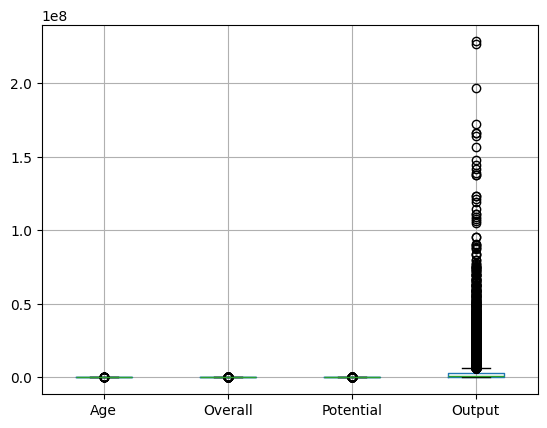

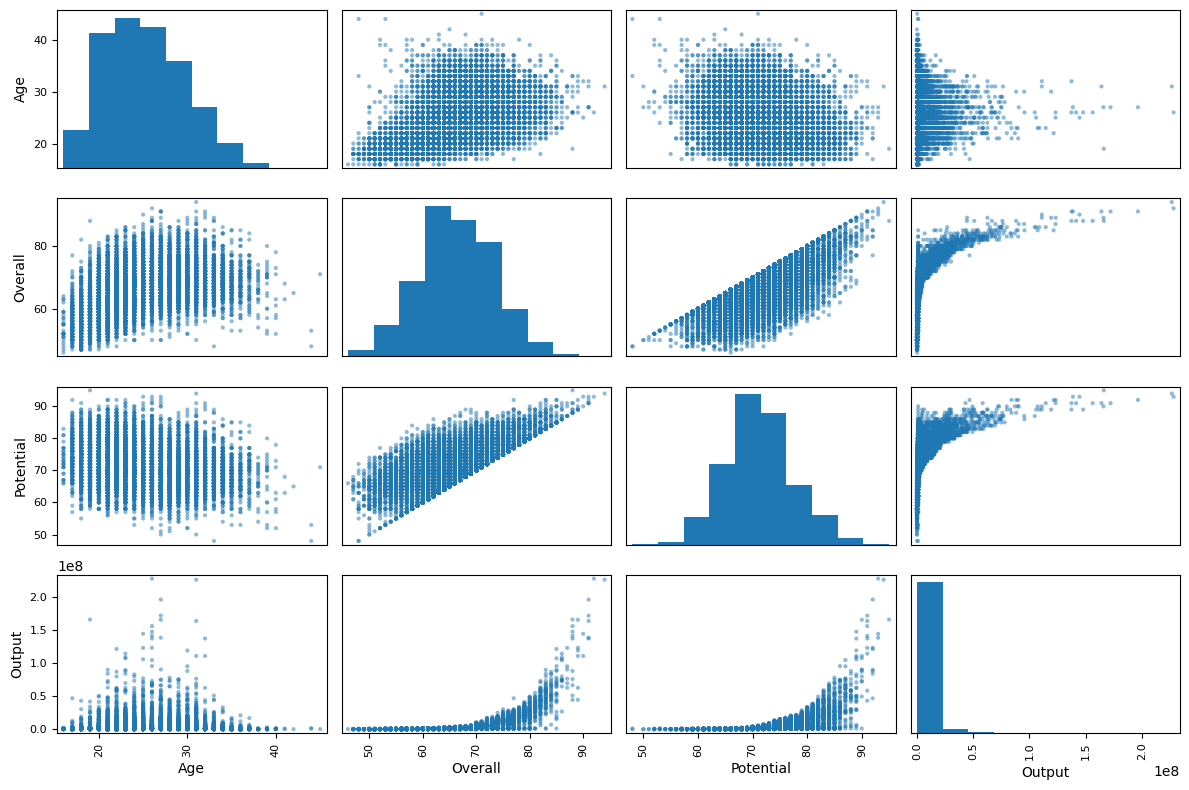

In [22]:
from pandas.plotting import scatter_matrix

Xm.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()

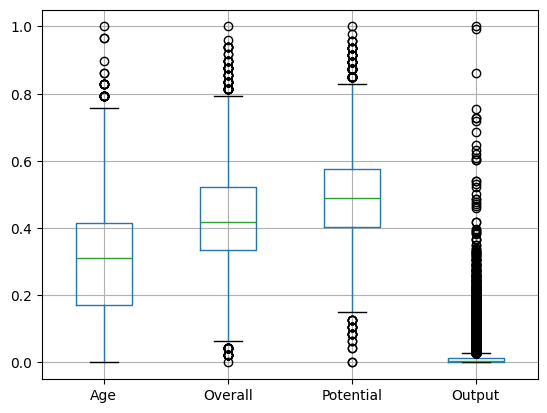

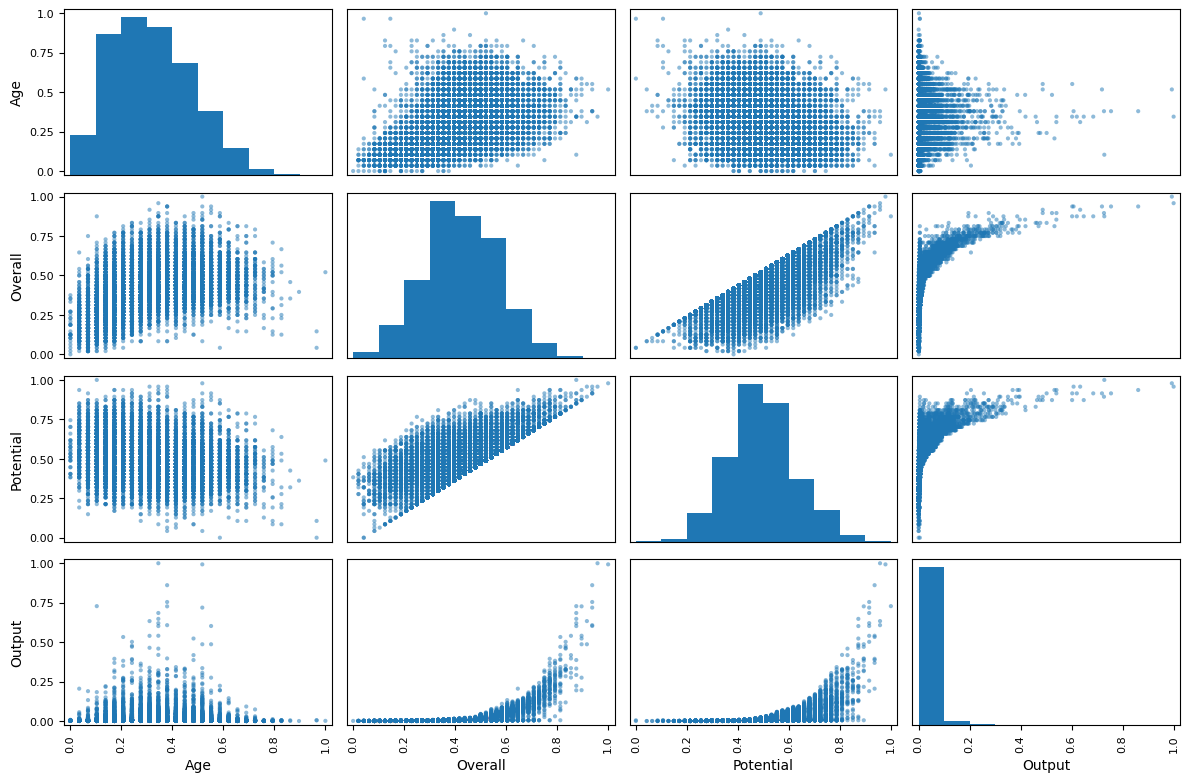

In [23]:
from sklearn.preprocessing import MinMaxScaler
#scaler = StandardScaler()
scaler = MinMaxScaler()

Xm_pre_sca = pd.DataFrame(scaler.fit_transform(Xm),columns=Xm.columns)
Xm_pre_sca.boxplot()#grafica de caja
plt.show()
scatter_matrix(Xm_pre_sca, figsize=(12, 8)) #scatter con histogramas
plt.tight_layout()
plt.show()


# Se define pipeline para entrenar un modelo de regresión

**Nota:** Se sugiere utilizar un preproceso de normalización tipo StandardScaler o MinMaxScaler para evitar problemas de escala a la hora de identificar los patrones de interés.


A continuación se genera pipeline completo inlcuyendo preproceso custom, standardscaler y modelo de regresión lineal por mínimos cuadrados.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
steps = [('preproceso',mypre_fifa(col_euro=col_euro,col_stats=col_stats,cat_usr = cat_usr)),
         ('scaler', StandardScaler()),
         ('regresion',LinearRegression())
         ]
metodo_full = Pipeline(steps=steps)
metodo_full.fit(Xtrain,ytrain_num) #entrena todos los pasos

Pipeline(steps=[('preproceso',
                 mypre_fifa(cat_usr={'Body Type': ['Normal', 'Lean', 'Stocky',
                                                   'Messi', 'C. Ronaldo',
                                                   'Neymar', 'Courtois',
                                                   'PLAYER_BODY_TYPE_25',
                                                   'Shaqiri', 'Akinfenwa'],
                                     'Club': ['Fortuna Düsseldorf',
                                              'FC Barcelona',
                                              'Newcastle United', 'Frosinone',
                                              'CD Leganés', 'Rayo Vallecano',
                                              'Empoli', 'Cardiff City',
                                              'AS Monaco',
                                              'TSG 1899 Hoffenheim',
                                              'Eintracht Frankfurt',
                                              'Ma...
                                     'Work Rate': ['Medium/ Medium',
                                                   'High/ Medium',
                                                   'Medium/ High', 'High/ High',
                                                   'Medium/ Low', 'High/ Low',
                                                   'Low/ Medium', 'Low/ High',
                                                   'Low/ Low']},
                            col_euro=['Value', 'Wage'],
                            col_stats=['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF',
                                       'RW', 'LAM', 'CAM', 'RAM', 'LM', 'LCM',
                                       'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
                                       'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB',
                                       'RB'])),
                ('scaler', StandardScaler()),
                ('regresion', LinearRegression())])

In [25]:
ytest_e = metodo_full.predict(Xtest) #se evalua el desempeño en el conjunto de test


Se grafican salida original y las predicciones

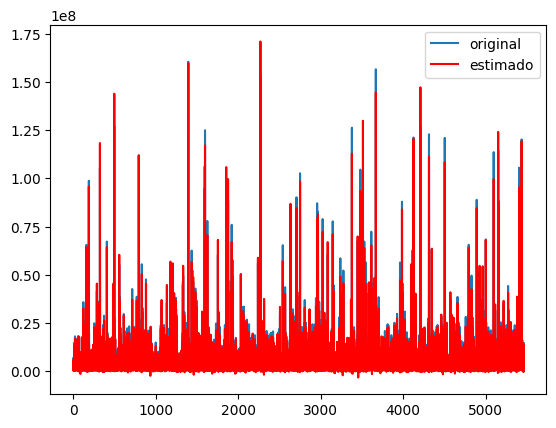

In [26]:
plt.plot(ytest_num,label='original')
plt.plot(ytest_e,'r',label='estimado')

plt.legend()
plt.show()

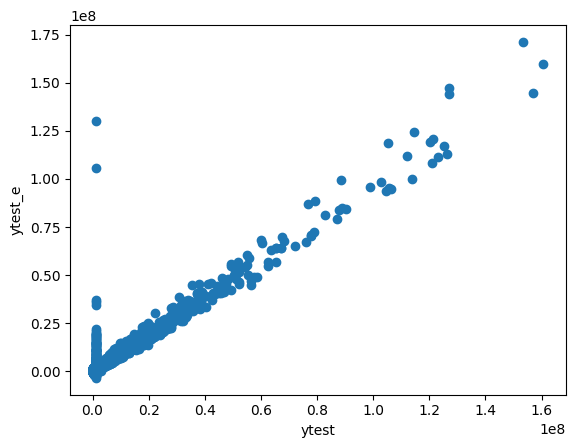

In [27]:
plt.scatter(ytest_num,ytest_e)
plt.xlabel('ytest')
plt.ylabel('ytest_e')
plt.show()

# Ejercicio 3

1. Utilizando el método steps del pipeline, realice una gráfica de las cargas (pesos) del modelo lineal entrenado. Qué puede discutir al respecto?

2. Consulte y presente el modelo y problema de optimización de los siguientes regresores:

 - [LinearRegresor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
 - [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
 - [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
 - [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)
 - [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html)
 - [BayesianRidge](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-ridge-regression)
 - [Gaussian Process Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html)

3. Utilizando un esquema de validación cruzada de 5 folds sobre el conjunto de entrenamiento preprocesado, compare el rendimiento en el conjunto de test de los regresores del punto 2. fijando el score del [gridsearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) en términos del error absoluto medio y el error cuádratico medio. Justifique los hiperparámetros a buscar y la rejilla de valores escogida para cada algoritmo según los modelos estudiados en clase y las respuestas del punto 2. Para el caso del kernelRidge y GPR se sugiere trabajar sobre un conjunto de train de 5000 puntos para evitar problemas de memoría en los cálculos de la matriz kernel (presente los resultados para kernel ridge utilizando una función rbf).



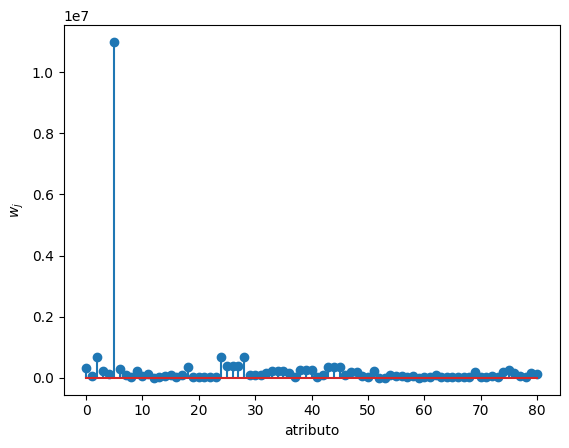

In [28]:
#Ayuda punto 1:
#el pipeline contiene el método steps codificando los elementos del proceso.
#En este caso el regresor esta en la posición 2 y en la 1 de la tupla arrojada
#Revisando la documentación de LinearRegression, el atributo coef_ contiene las cargas del modelo
plt.stem(abs(metodo_full.steps[2][1].coef_))
plt.xlabel('atributo')
plt.ylabel('$w_j$')
plt.show()

In [29]:
#Ayuda punto 2 y 3
#Dado que el preproceso no cambia, se sugiera generar el pipeline sin mypre_fifa para ahorrar tiempo
steps = [('scaler', StandardScaler()), #ajustar según ejercicio
         ('regresion',LinearRegression()) #ajustar según ejercicio
         ]
metodo_gs = Pipeline(steps=steps) #pipeline a utilizar en el gridsearch
#Recuerde realizar el fit del gridsearch sobre las matrices de entrada y vector de salida preprocesados
#Xtrain_pre ytrain_num


# **solucion**

1.


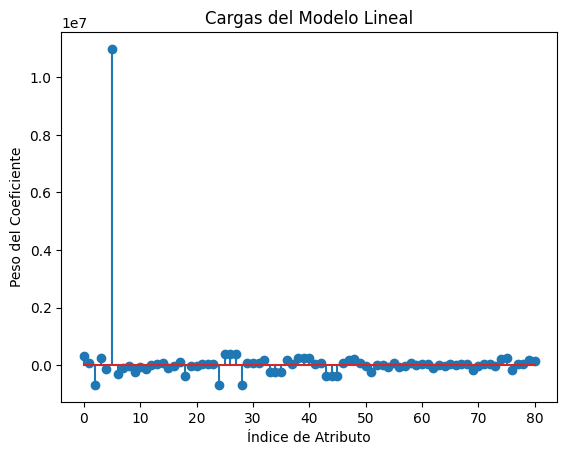

In [30]:
import matplotlib.pyplot as plt

# Acceder a los coeficientes del modelo lineal
coeficientes = metodo_full.steps[2][1].coef_

# Crear la gráfica
plt.stem(coeficientes)
plt.xlabel("Índice de Atributo")
plt.ylabel("Peso del Coeficiente")
plt.title("Cargas del Modelo Lineal")
plt.show()


* Los coeficientes muestran cómo cada atributo influye en la salida del modelo.
* Atributos con coeficientes más grandes (positivos o negativos) tienen un impacto mayor en las predicciones.
* Coeficientes cercanos a cero sugieren  que el modelo considera que esos atributos tienen poco o ningún efecto en la salida.

* Observar patrones como grupos de atributos con pesos similares o coeficientes dominantes puede indicar cuáles son los factores más relevantes para las predicciones.

3.

In [31]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# Se parte de que ya tienes los datos preprocesados (Xtrain_pre, Xtest_pre, ytrain_num, ytest_num)

# Trabajamos sobre una muestra de 5000 puntos para evitar problemas de memoria en Kernel Ridge y GPR
Xtrain_subsample, _, ytrain_subsample, _ = train_test_split(Xtrain_pre, ytrain_num, train_size=5000, random_state=42)

# Definimos los modelos y sus rejillas de hiperparámetros
models_and_parameters = {
    'LinearRegression': (LinearRegression(), {}),
    'Lasso': (Lasso(), {'alpha': [0.001, 0.01, 0.1, 1, 10]}),
    'ElasticNet': (ElasticNet(), {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}),
    'KernelRidge': (KernelRidge(kernel='rbf'), {'alpha': [0.01, 0.1, 1], 'gamma': [0.1, 1, 10]}),
    'SGDRegressor': (SGDRegressor(max_iter=1000), {'alpha': [0.0001, 0.001, 0.01]}),
    'BayesianRidge': (BayesianRidge(), {}),
    'GaussianProcessRegressor': (GaussianProcessRegressor(kernel=RBF()), {'alpha': [1e-10, 1e-8, 1e-6],
                                                                          'kernel': [RBF(0.1), RBF(1.0), RBF(10.0)]})
}


# Evaluación con GridSearchCV y validación cruzada de 5 pliegues
results = {}
for idx, (model_name, (model, param_grid)) in enumerate(models_and_parameters.items(), start=1):
    print(f"Entrenando modelo {idx}/{len(models_and_parameters)}: {model_name}...")

    # Elegimos el conjunto de entrenamiento reducido si es necesario
    if model_name in ['KernelRidge', 'GaussianProcessRegressor']:
        Xtrain_to_use, ytrain_to_use = Xtrain_subsample, ytrain_subsample
    else:
        Xtrain_to_use, ytrain_to_use = Xtrain_pre, ytrain_num

    # Configuramos el GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

    # Ajustamos el modelo
    grid_search.fit(Xtrain_to_use, ytrain_to_use)

    # Almacenamos resultados
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_mse = -grid_search.best_score_
    ypred = best_model.predict(Xtest_pre)
    test_mae = mean_absolute_error(ytest_num, ypred)
    test_mse = mean_squared_error(ytest_num, ypred)

    results[model_name] = {
        'best_params': best_params,
        'train_mse': best_mse,
        'test_mae': test_mae,
        'test_mse': test_mse
    }

    # Reportamos el estado
    print(f"Modelo {model_name} entrenado.")
    print(f"Mejor parámetro: {best_params}")
    print(f"Error cuadrático medio en validación cruzada: {best_mse}")
    print("-" * 50)

print("Entrenamiento completado para todos los modelos.")

# Mostrar resultados finales
for model_name, result in results.items():
    print(f"Model: {model_name}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Train MSE: {result['train_mse']}")
    print(f"Test MAE: {result['test_mae']}")
    print(f"Test MSE: {result['test_mse']}")
    print("-" * 50)


Entrenando modelo 1/7: LinearRegression...
Modelo LinearRegression entrenado.
Mejor parámetro: {}
Error cuadrático medio en validación cruzada: 5455931650208.097
--------------------------------------------------
Entrenando modelo 2/7: Lasso...
Modelo Lasso entrenado.
Mejor parámetro: {'alpha': 10}
Error cuadrático medio en validación cruzada: 5453534150334.297
--------------------------------------------------
Entrenando modelo 3/7: ElasticNet...
Modelo ElasticNet entrenado.
Mejor parámetro: {'alpha': 0.1, 'l1_ratio': 0.5}
Error cuadrático medio en validación cruzada: 5449916668507.101
--------------------------------------------------
Entrenando modelo 4/7: KernelRidge...
Modelo KernelRidge entrenado.
Mejor parámetro: {'alpha': 0.01, 'gamma': 0.1}
Error cuadrático medio en validación cruzada: 114329420782800.0
--------------------------------------------------
Entrenando modelo 5/7: SGDRegressor...
Modelo SGDRegressor entrenado.
Mejor parámetro: {'alpha': 0.0001}
Error cuadrático med

**LinearRegression**

Hiperparámetros: Ninguno.

Justificación: Este modelo no tiene hiperparámetros clave que ajustar, ya que simplemente ajusta una solución cerrada de mínimos cuadrados ordinarios. Se utiliza como línea base para comparar otros modelos más complejos.

**Lasso**

Hiperparámetro: alpha.

Rejilla: [0.001, 0.01, 0.1, 1, 10].

Justificación: alpha controla la fuerza de la regularización L1, lo que afecta cuántos coeficientes se reducen a cero. Valores bajos de alpha permiten ajustes más precisos pero menos regularización (potencialmente sobreajustando), mientras que valores altos de alpha inducen una mayor penalización, eliminando más características irrelevantes. Esta rejilla cubre un rango suficiente para observar cómo responde el modelo a diferentes niveles de regularización.

**ElasticNet**

Hiperparámetros: alpha y l1_ratio.
Rejilla: alpha: [0.001, 0.01, 0.1, 1, 10], l1_ratio: [0.2, 0.5, 0.8].
Justificación: alpha controla la magnitud de la regularización combinada, mientras que l1_ratio ajusta la mezcla entre L1 y L2. Esto permite explorar la transición desde un enfoque más Lasso (valores altos de l1_ratio) hacia un enfoque más Ridge (valores bajos de l1_ratio), identificando el punto óptimo en términos de sesgo y varianza. La rejilla de valores garantiza que evaluemos tanto penalizaciones leves como severas.

**KernelRidge**

Hiperparámetros: alpha y gamma.
Rejilla: alpha: [0.01, 0.1, 1], gamma: [0.1, 1, 10].
Justificación: alpha regula el grado de regularización para evitar el sobreajuste. gamma controla la escala del kernel RBF (el alcance de la influencia de cada muestra). Un gamma pequeño permite una mayor suavización, mientras que un gamma grande se ajusta más finamente a los datos locales. La rejilla proporciona un rango razonable de regularización y diferentes grados de suavidad en la transformación del espacio de características.
Nota: Trabajar sobre un conjunto reducido de 5000 puntos es importante aquí porque el kernel RBF requiere construir y operar con matrices cuadradas de tamaño N x N, lo que puede ser muy costoso en memoria y computación para N grande.

**SGDRegressor**

Hiperparámetro: alpha.
Rejilla: [0.0001, 0.001, 0.01].
Justificación: alpha determina la fuerza de la regularización durante el entrenamiento iterativo. Valores pequeños permiten un aprendizaje más fino pero más lento y potencialmente ruidoso, mientras que valores mayores inducen más regularización, ayudando a controlar el sobreajuste. Los valores propuestos son comunes para ajustar modelos lineales con regularización L2.

**BayesianRidge**

Hiperparámetros: Ninguno (por defecto en esta implementación).
Justificación: Aunque internamente tiene parámetros hiperpriors (como alpha_1, alpha_2, lambda_1, lambda_2), aquí estamos utilizando los valores predeterminados. La flexibilidad de este modelo radica en que las distribuciones bayesianas se ajustan automáticamente según los datos.
GaussianProcessRegressor

**Hiperparámetros: alpha y kernel.**

Rejilla: alpha: [1e-10, 1e-8, 1e-6], kernel: [RBF(0.1), RBF(1.0), RBF(10.0)].
Justificación: alpha representa un nivel de ruido en el modelo. Valores pequeños asumen menos ruido, haciendo que el modelo confíe más en los datos, mientras que valores más altos regularizan el modelo al suavizar las predicciones. La elección de distintos parámetros para el kernel RBF permite probar radios de influencia diferentes. La rejilla explora combinaciones para encontrar un balance entre suavidad y capacidad de ajuste.